## Generating Dataset
Let's create the toy dataset. We'll have a 1 16x16 image with a 4x4 square placed somewhere inside.

<IPython.core.display.Javascript object>


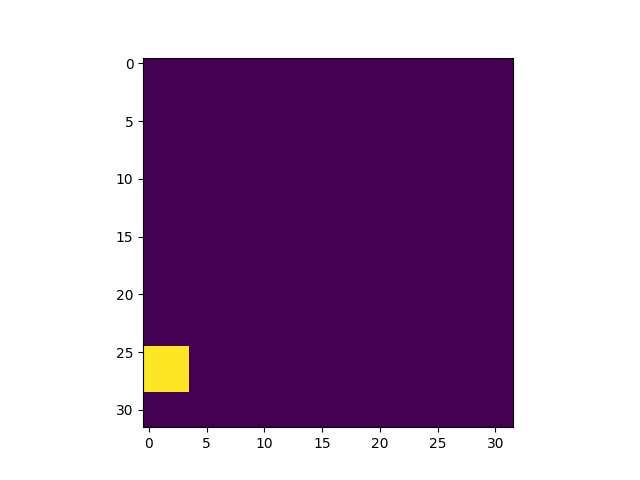

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
for i in range(5):

    img = np.zeros((1,3,32,32), dtype=np.float32)
    pos_r = np.random.randint(0, img.shape[2]-4-1)
    pos_c = np.random.randint(0, img.shape[3]-4-1)
    img[0,:,pos_r:pos_r+4,pos_c:pos_c+4]=1
    plt.imshow(img[0,0,:,:])
    plt.show()

## Generating Feature maps
Now that we have the image, we'll go over it one by one and generate feature maps of size 4x4.

In [18]:
from chainer import Chain
import chainer
import chainer.functions as F
import chainer.links as L

class ConvNet(Chain):
    def __init__(self):
        super(ConvNet, self).__init__(
            l1=L.Convolution2D(None,32,ksize=(3,3),stride=1,pad=1),
            l2=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1),
            l3=L.Convolution2D(32,32,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.max_pooling_2d(h1, 2)
        h3 = F.relu(self.l2(h2))
        h4 = F.max_pooling_2d(h3, 2)
        h5 = F.relu(self.l3(h4))
        h6 = F.max_pooling_2d(h5, 2)
        return self.l3(F.sigmoid(h6))

## Linear Convolution to generate shifts

In [19]:
class BoxNet(Chain):
    def __init__(self):
        super(BoxNet, self).__init__(
            l1=L.Convolution2D(None,6,ksize=(3,3),stride=1,pad=1)
        )
        
    def __call__(self, x):
        h1 = self.l1(x)
        return h1
    
convnet = ConvNet()
boxnet = BoxNet()
fm = convnet(img)
shifts = boxnet(fm)
shifts= shifts.reshape(4*4,6)
shifts.dtype

dtype('float32')

## Draw generated default boxes on top of the original image

<IPython.core.display.Javascript object>


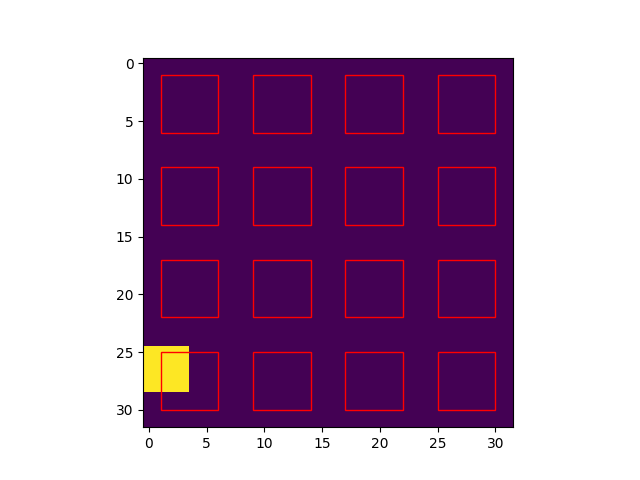

(3.5, 27.5, 5.0, 5.0, 0.0, 0.0)

In [20]:
from matplotlib import patches

# Function to generate default boxes
def defaultgen( I, F, width, height): 
    """
    Generates an array of default boxes: TESTED
    
    Args:
        I: Input image tensor (N,channels,rows,cols)
        F: Feature map tensor to generate default boxes for
        width: Width of the box
        height: Height of the box
        
    Returns:
        db: Default boxes tensor, flattened
    """
    boxes = np.zeros((F.shape[2], F.shape[3], 6))
    scale = (I.shape[2]/ F.shape[2])
    
    for i in range(F.shape[2]): 
        for j in range(F.shape[3]): 
            
            # d depends on the number of max pooling layers
            cx  = ((( scale- 1)/ 2 )+ (j*(scale )))
            cy  = (((scale - 1)/ 2 )+ (i*(scale ))) 
            
            boxes[i,j,:] = np.array([cx,cy,width, height, 0, 0])
            
    return boxes.reshape(F.shape[2] * F.shape[3], 6)

def center_to_coords(box):
    """ 
    Converts bounding box from (cx, cy, w, h) format to (x1, y1, x2, y2) format
    
    Args:
        box: 6d numpy array
        
    Returns:
        box_transformed: Box in the second format
    
    """
    box_transformed = np.array([box[0]-box[2]/2.0, box[1]+box[3]/2.0, box[0]+box[2]/2.0, box[1]-box[3]/2.0, box[4], box[5]])
    return box_transformed


def draw_boxes(img, boxes, color='red'):
    plt.figure()
    ax = plt.axes()

    for box in boxes:
        box = center_to_coords(box)
        ax.imshow(img[0,0,:,:])
        p = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = color)
        ax.add_patch(p)

    plt.show()

def_boxes = defaultgen(img, fm, 5,5)

def_boxes[0][2:4]

draw_boxes(img, def_boxes,color = 'red')
tuple(def_boxes[12])

## Draw predictions on top of the original image
Now with the shift tensor we have obtained from running convnet and boxnet together, let's offset the default boxes.

In [21]:
def get_pred_boxes(shift_vals, default_boxes ): 
    """
    Get predicted boxes by combining shift values to default boxes
    Input: 

    shift_values : Shifts generated by the network  NDarray (None, Num of Default boxes, 4+num of classes)
    Default boxes  : Default boxes generated by the network NDarray (None, Num of Default boxes, 4+num of classes)

    Output: 

    Predicted boxes  : Predicted boxes, same shape as default boxes  NDarray (None, Num of Default boxes, 4+num of classes)

    """

    def_boxes +shifts
    
    cx_pred = (shifts[:,0]*shifts[:,2])+def_boxes[:,0]
    cy_pred = (shifts[:,1]*shifts[:,2])+def_boxes[:,1]
    
    H_pred = F.exp(shifts[:,2])*def_boxes[:,2]
    W_pred = F.exp(shifts[:,3])*def_boxes[:,3]
    
    class1 = shifts[:,4]
    class2 = shifts[:,5]
    
    
    pred_boxes = F.vstack((cx_pred,cy_pred,W_pred,H_pred, class1, class2))
    pred_boxes = F.transpose(pred_boxes)
    
    return  pred_boxes 
    
    

pred_boxes = get_pred_boxes(shifts, def_boxes)


<IPython.core.display.Javascript object>


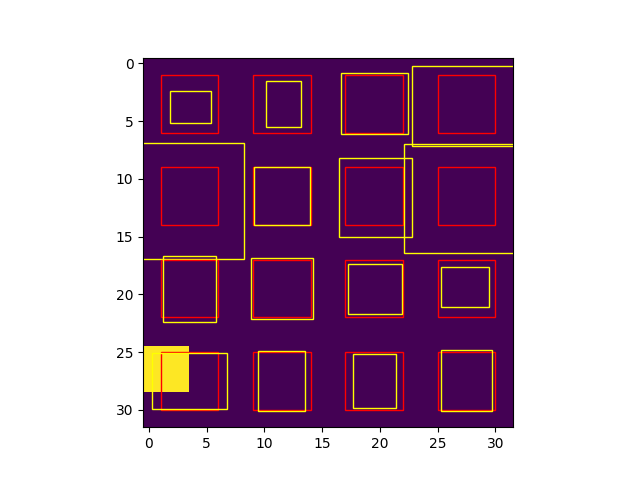

In [22]:

def draw_pred_boxes(prediction_boxes, default_boxes): 
    """Draw predicted boxes on the original image """
    
    pred_boxes= prediction_boxes
    def_boxes =default_boxes
    pred_boxes = get_pred_boxes(shifts, def_boxes)
     
    boxes = pred_boxes.data
    
    plt.figure()
    ax = plt.axes()

    for i in range(def_boxes.shape[0]):
        box = def_boxes[i]
        box2 =boxes[i]            
        box = center_to_coords(box)
        box2 = center_to_coords(box2)            
        ax.imshow(img[0,0,:,:])

        default_boxes = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color = 'red')
        pred_boxes = patches.Rectangle((box2[0], box2[1]), box2[2]-box2[0], box2[3]-box2[1], fill=False, color = 'yellow')

        ax.add_patch(default_boxes)
        ax.add_patch(pred_boxes)


    plt.show()
#     plt.savefig('shifts')



draw_pred_boxes(pred_boxes, def_boxes)


## Do matching

## Compute classification loss (brute force for loop cpu)

## Compute regression loss (brute force for loop cpu)